# Übung 2: Machine Learning
Fink Lucas, 26.04.2025

#### Packages und Daten importieren

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error
import joblib

dirpath = './Daten/'
bike_rental = pd.read_csv(dirpath + 'Bike_rental_modified.csv')

## 1) Training linearer Modelle

In [3]:
columns = ['intday', 'season', 'yr', 'mnth', 'holiday',
       'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed']

X = bike_rental[columns]  # Trainingsfeatures
y = bike_rental['cnt']    # Trainingslabels

##### Aufteilen des Datensatzes in Trainings und Validierungsdaten

In [4]:
n_valid = int(0.8 * X.shape[0])

X_train = X[:n_valid]
X_valid = X[n_valid:]
y_train = y[:n_valid]
y_valid = y[n_valid:]

##### Feature Transformation und Normalisierung der Daten

In [5]:
enc_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']
num_features = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed']

enc = OneHotEncoder(sparse_output=False, handle_unknown= 'ignore')  # macht aus einem Feature zB 7 für Wochentage

X_train_enc = enc.fit_transform(X_train[enc_features]) # transformiert die Daten 0-6 Wochentage 
X_train_enc = pd.DataFrame(X_train_enc, columns = enc.get_feature_names_out(enc_features))

X_valid_enc = enc.transform(X_valid[enc_features])
X_valid_enc = pd.DataFrame(X_valid_enc, columns = enc.get_feature_names_out(enc_features))

scaler = MaxAbsScaler()     # dividiert durch den größten Betrag um einen Wert zwischen 0 und 1 zu bekommen
X_train_scale = scaler.fit_transform(X_train[num_features])
X_train_scale = pd.DataFrame(X_train_scale, columns = num_features)

X_valid_scale = scaler.transform(X_valid[num_features])
X_valid_scale = pd.DataFrame(X_valid_scale, columns = num_features)


X_train_final = pd.concat((X_train_enc, X_train_scale), axis=1)
X_valid_final = pd.concat((X_valid_enc, X_valid_scale), axis=1)

### Lineares Modell: Methode -> Ridge
Es wird das Ridge Regressions Modell initialisiert. Es wird ein Suchgitter für den Hyperparameter 'alpha' definiert.
* Alpha steuert die Stärke der Regularisierung
* Modell wird mit 5-facher Kreuzvalidierung(cv) getestet 

In [82]:
alpha_values = np.logspace(-6, 3, 40)  # alpha Werte von 1e-4 bis 1e3
gamma_values = np.logspace(-6, 2, 10)  # gamma Werte von 1e-4 bis 1e2
param_grid = {'alpha':alpha_values}
kernelRidge_param_grid = {'alpha':alpha_values, 'gamma':gamma_values}

In [83]:
ridge_model = Ridge()
ridge_search_cv = GridSearchCV(ridge_model, param_grid, cv = 5, verbose = 3,scoring = 'neg_mean_squared_error', return_train_score= True)
ridge_search_cv.fit(X_train_final, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END alpha=1e-06;, score=(train=-352940.304, test=-380414.257) total time=   0.0s
[CV 2/5] END alpha=1e-06;, score=(train=-318361.232, test=-1481671.218) total time=   0.0s
[CV 3/5] END alpha=1e-06;, score=(train=-262328.795, test=-789779.390) total time=   0.0s
[CV 4/5] END alpha=1e-06;, score=(train=-310804.935, test=-572262.018) total time=   0.0s
[CV 5/5] END alpha=1e-06;, score=(train=-319797.564, test=-3044687.151) total time=   0.0s
[CV 1/5] END alpha=1.7012542798525892e-06;, score=(train=-352940.304, test=-380414.344) total time=   0.0s
[CV 2/5] END alpha=1.7012542798525892e-06;, score=(train=-318361.232, test=-1481670.656) total time=   0.0s
[CV 3/5] END alpha=1.7012542798525892e-06;, score=(train=-262328.795, test=-789779.882) total time=   0.0s
[CV 4/5] END alpha=1.7012542798525892e-06;, score=(train=-310804.935, test=-572261.651) total time=   0.0s
[CV 5/5] END alpha=1.7012542798525892e-06;, score=(train=

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 1.70125428e-06, 2.89426612e-06, 4.92388263e-06,
       8.37677640e-06, 1.42510267e-05, 2.42446202e-05, 4.12462638e-05,
       7.01703829e-05, 1.19377664e-04, 2.03091762e-04, 3.45510729e-04,
       5.87801607e-04, 1.00000000e-03, 1.70125428e-03, 2.89426612e-03,
       4.92388263e-03, 8.37677640e-03, 1.42510267e-02, 2....
       4.12462638e-02, 7.01703829e-02, 1.19377664e-01, 2.03091762e-01,
       3.45510729e-01, 5.87801607e-01, 1.00000000e+00, 1.70125428e+00,
       2.89426612e+00, 4.92388263e+00, 8.37677640e+00, 1.42510267e+01,
       2.42446202e+01, 4.12462638e+01, 7.01703829e+01, 1.19377664e+02,
       2.03091762e+02, 3.45510729e+02, 5.87801607e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

### Lineares Modell: Methode -> Lasso

In [84]:
lasso_model = Lasso()
lasso_search_cv = GridSearchCV(lasso_model, param_grid, cv=5,  verbose=2, scoring='neg_mean_squared_error', return_train_score= True)
lasso_search_cv.fit(X_train_final, y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END .......................alpha=1.7012542798525892e-06; total time=   0.0s
[CV] END .......................alpha=1.7012542798525892e-06; total time=   0.0s
[CV] END .......................alpha=1.7012542798525892e-06; total time=   0.0s
[CV] END .......................alpha=1.7012542798525892e-06; total time=   0.0s
[CV] END .......................alpha=1.7012542798525892e-06; total time=   0.0s
[CV] END ........................alpha=2.894266124716752e-06; total time=   0.0s
[CV] END ........................alpha=2.894266

c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.155e+07, tolerance: 3.911e+04
  model = cd_fast.enet_coordinate_descent(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.552e+07, tolerance: 6.233e+04
  model = cd_fast.enet_coordinate_descent(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

[CV] END ........................alpha=8.376776400682924e-06; total time=   0.0s
[CV] END .......................alpha=1.4251026703029993e-05; total time=   0.0s
[CV] END .......................alpha=1.4251026703029993e-05; total time=   0.0s
[CV] END .......................alpha=1.4251026703029993e-05; total time=   0.0s
[CV] END .......................alpha=1.4251026703029993e-05; total time=   0.0s
[CV] END .......................alpha=1.4251026703029993e-05; total time=   0.0s
[CV] END ........................alpha=2.424462017082331e-05; total time=   0.0s
[CV] END ........................alpha=2.424462017082331e-05; total time=   0.0s
[CV] END ........................alpha=2.424462017082331e-05; total time=   0.0s
[CV] END ........................alpha=2.424462017082331e-05; total time=   0.0s
[CV] END ........................alpha=2.424462017082331e-05; total time=   0.0s
[CV] END ........................alpha=4.124626382901348e-05; total time=   0.0s
[CV] END ...................

c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.921e+07, tolerance: 6.622e+04
  model = cd_fast.enet_coordinate_descent(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.458e+07, tolerance: 3.911e+04
  model = cd_fast.enet_coordinate_descent(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

[CV] END .......................alpha=0.00011937766417144369; total time=   0.0s
[CV] END .......................alpha=0.00020309176209047368; total time=   0.0s
[CV] END .......................alpha=0.00020309176209047368; total time=   0.0s
[CV] END .......................alpha=0.00020309176209047368; total time=   0.0s
[CV] END .......................alpha=0.00020309176209047368; total time=   0.0s
[CV] END .......................alpha=0.00020309176209047368; total time=   0.0s
[CV] END ........................alpha=0.0003455107294592222; total time=   0.0s
[CV] END ........................alpha=0.0003455107294592222; total time=   0.0s
[CV] END ........................alpha=0.0003455107294592222; total time=   0.0s
[CV] END ........................alpha=0.0003455107294592222; total time=   0.0s
[CV] END ........................alpha=0.0003455107294592222; total time=   0.0s
[CV] END ........................alpha=0.0005878016072274912; total time=   0.0s
[CV] END ...................

c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e+07, tolerance: 3.911e+04
  model = cd_fast.enet_coordinate_descent(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.543e+06, tolerance: 6.233e+04
  model = cd_fast.enet_coordinate_descent(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

[CV] END ........................alpha=0.0028942661247167516; total time=   0.0s
[CV] END ........................alpha=0.0028942661247167516; total time=   0.0s
[CV] END ........................alpha=0.0028942661247167516; total time=   0.0s
[CV] END ........................alpha=0.0028942661247167516; total time=   0.0s
[CV] END ........................alpha=0.0028942661247167516; total time=   0.0s
[CV] END .........................alpha=0.004923882631706742; total time=   0.0s
[CV] END .........................alpha=0.004923882631706742; total time=   0.0s
[CV] END .........................alpha=0.004923882631706742; total time=   0.0s
[CV] END .........................alpha=0.004923882631706742; total time=   0.0s
[CV] END .........................alpha=0.004923882631706742; total time=   0.0s
[CV] END .........................alpha=0.008376776400682925; total time=   0.0s
[CV] END .........................alpha=0.008376776400682925; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.70125428e-06, 2.89426612e-06, 4.92388263e-06,
       8.37677640e-06, 1.42510267e-05, 2.42446202e-05, 4.12462638e-05,
       7.01703829e-05, 1.19377664e-04, 2.03091762e-04, 3.45510729e-04,
       5.87801607e-04, 1.00000000e-03, 1.70125428e-03, 2.89426612e-03,
       4.92388263e-03, 8.37677640e-03, 1.42510267e-02, 2....
       4.12462638e-02, 7.01703829e-02, 1.19377664e-01, 2.03091762e-01,
       3.45510729e-01, 5.87801607e-01, 1.00000000e+00, 1.70125428e+00,
       2.89426612e+00, 4.92388263e+00, 8.37677640e+00, 1.42510267e+01,
       2.42446202e+01, 4.12462638e+01, 7.01703829e+01, 1.19377664e+02,
       2.03091762e+02, 3.45510729e+02, 5.87801607e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

* Bei kleinen alpha Werten kommt es bei der Lasso Regularisierung häufig zu ConvergenceWarnings also Konvergenzproblemen.

### Lineares Modell: Methode -> KernelRidge (18s)

In [85]:
kernelRidge_model = KernelRidge(kernel='rbf')
kernelRidge_search_cv = GridSearchCV(kernelRidge_model, kernelRidge_param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error',return_train_score= True)
kernelRidge_search_cv.fit(X_train_final, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END ...........................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV] END ...........................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV] END ...........................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV] END ...........................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV] END ...........................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=7.742636826811277e-06; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=7.742636826811277e-06; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=7.742636826811277e-06; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=7.742636826811277e-06; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=7.742636826811277e-06; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=5.994842503189409e-05; total time=   0.0s
[CV] END ...........alpha=1e-06, gamma=5.9948

GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': array([1.00000000e-06, 1.70125428e-06, 2.89426612e-06, 4.92388263e-06,
       8.37677640e-06, 1.42510267e-05, 2.42446202e-05, 4.12462638e-05,
       7.01703829e-05, 1.19377664e-04, 2.03091762e-04, 3.45510729e-04,
       5.87801607e-04, 1.00000000e-03, 1.70125428e-03, 2.89426612e-03,
       4.92388263e-03, 8.37677640e-03...
       2.42446202e+01, 4.12462638e+01, 7.01703829e+01, 1.19377664e+02,
       2.03091762e+02, 3.45510729e+02, 5.87801607e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-06, 7.74263683e-06, 5.99484250e-05, 4.64158883e-04,
       3.59381366e-03, 2.78255940e-02, 2.15443469e-01, 1.66810054e+00,
       1.29154967e+01, 1.00000000e+02])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

* Bei KernelRidge kommt es ebenfalls zu Konvergenzproblemen wenn ein Alpha Wert 0 verwendet wird

Ausgabe des besten Hyperparameter (niedrigster MSE)

In [88]:
print(f"Beste Parameter für Ridge:        alpha = {float(ridge_search_cv.best_params_['alpha'])}")
print(f"Beste Parameter für Lasso:        alpha = {float(lasso_search_cv.best_params_['alpha'])}")
print(f"Beste Parameter für Kernel Ridge: alpha = {float(kernelRidge_search_cv.best_params_['alpha'])}, gamma = {float(kernelRidge_search_cv.best_params_['gamma'])}")


Beste Parameter für Ridge:        alpha = 0.5878016072274912
Beste Parameter für Lasso:        alpha = 2.8942661247167516
Beste Parameter für Kernel Ridge: alpha = 0.0028942661247167516, gamma = 0.003593813663804626


Alle Ergebnisse der Kreuzvalidierung für die Visualisierung/Analyse speichern

In [89]:
ridge_cv_results = pd.DataFrame(ridge_search_cv.cv_results_)
lasso_cv_results = pd.DataFrame(lasso_search_cv.cv_results_)
kernelRidge_cv_results = pd.DataFrame(kernelRidge_search_cv.cv_results_)


## 2) Grafische Darstellung, Over und Underfitting
* für sehr große alpha Werte ist die Modellkomplexität zu gering (großer Trainings und Test-Loss) -> Underfitting
* für sehr kleine alpha Werte ist die Modellkomplexität hoch (training loss klein, test loss groß) -> Overfitting

### Ridge

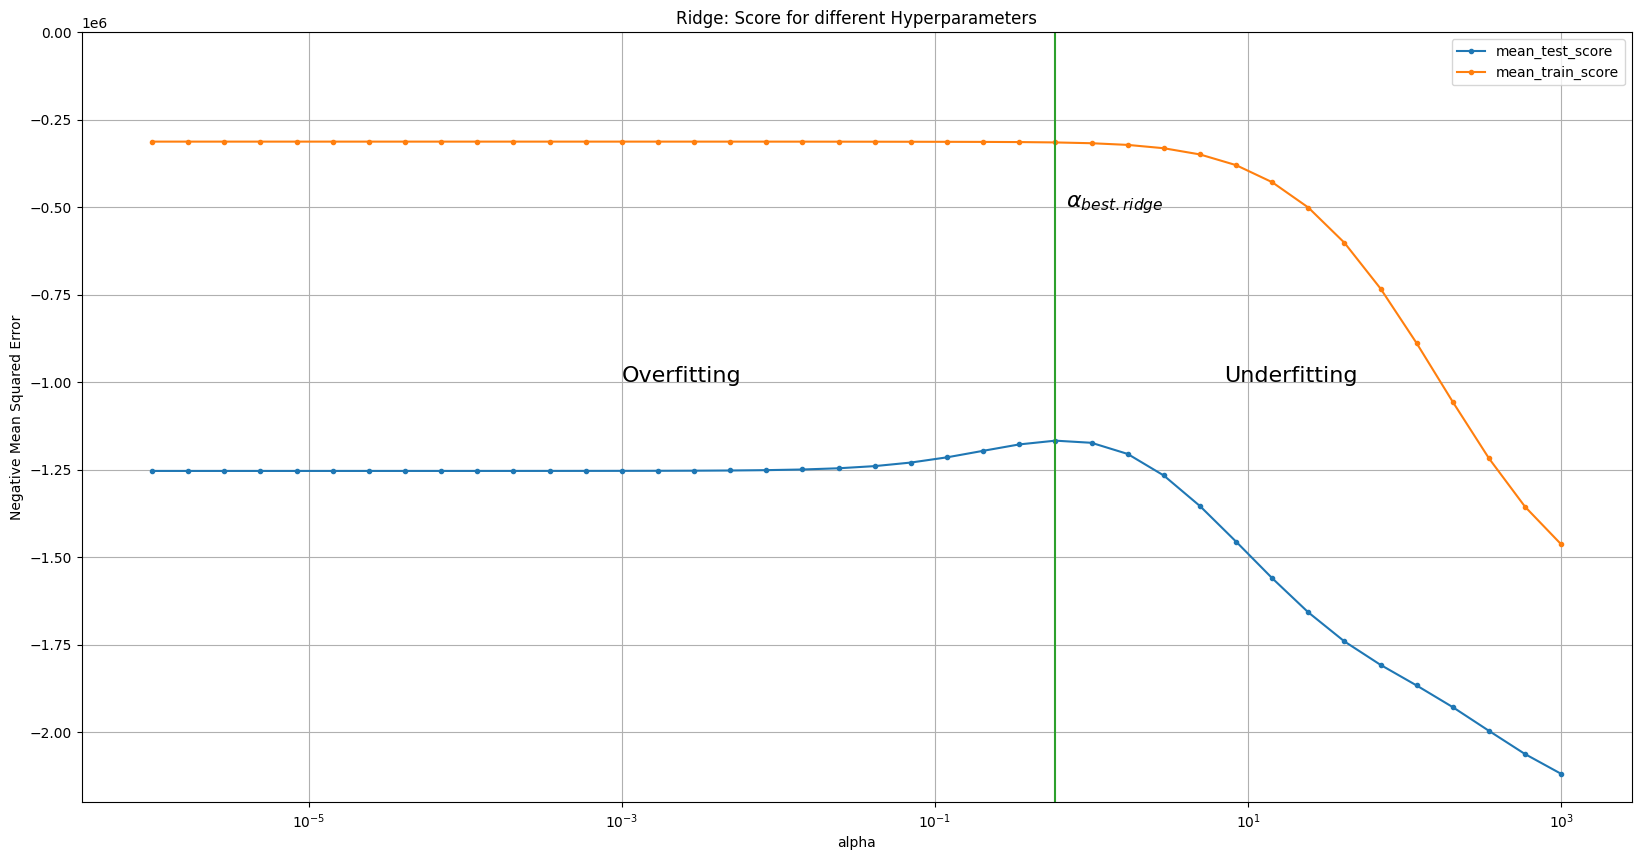

In [104]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.plot(param_grid['alpha'], ridge_cv_results['mean_test_score'], marker = '.', label='mean_test_score')
ax.plot(param_grid['alpha'], ridge_cv_results['mean_train_score'], marker = '.', label='mean_train_score')

ridge_alpha = ridge_search_cv.best_params_['alpha']
ax.plot([ridge_alpha, ridge_alpha],[-2.2e6, 0], ls = '-')
ax.text(ridge_alpha+0.1, -0.5e6, r'$\alpha_{best.ridge}$', fontsize=16, color='black')

ax.text(7, -1e6, 'Underfitting', fontsize=16, color='black')
ax.text(1e-3, -1e6, 'Overfitting', fontsize=16, color='black')

ax.set_ylim(-2.2e6, 0)
ax.set_xscale('log')
ax.set_title('Ridge: Score for different Hyperparameters')
ax.set_xlabel('alpha')
ax.set_ylabel('Negative Mean Squared Error')
ax.grid()
ax.legend()

### Lasso

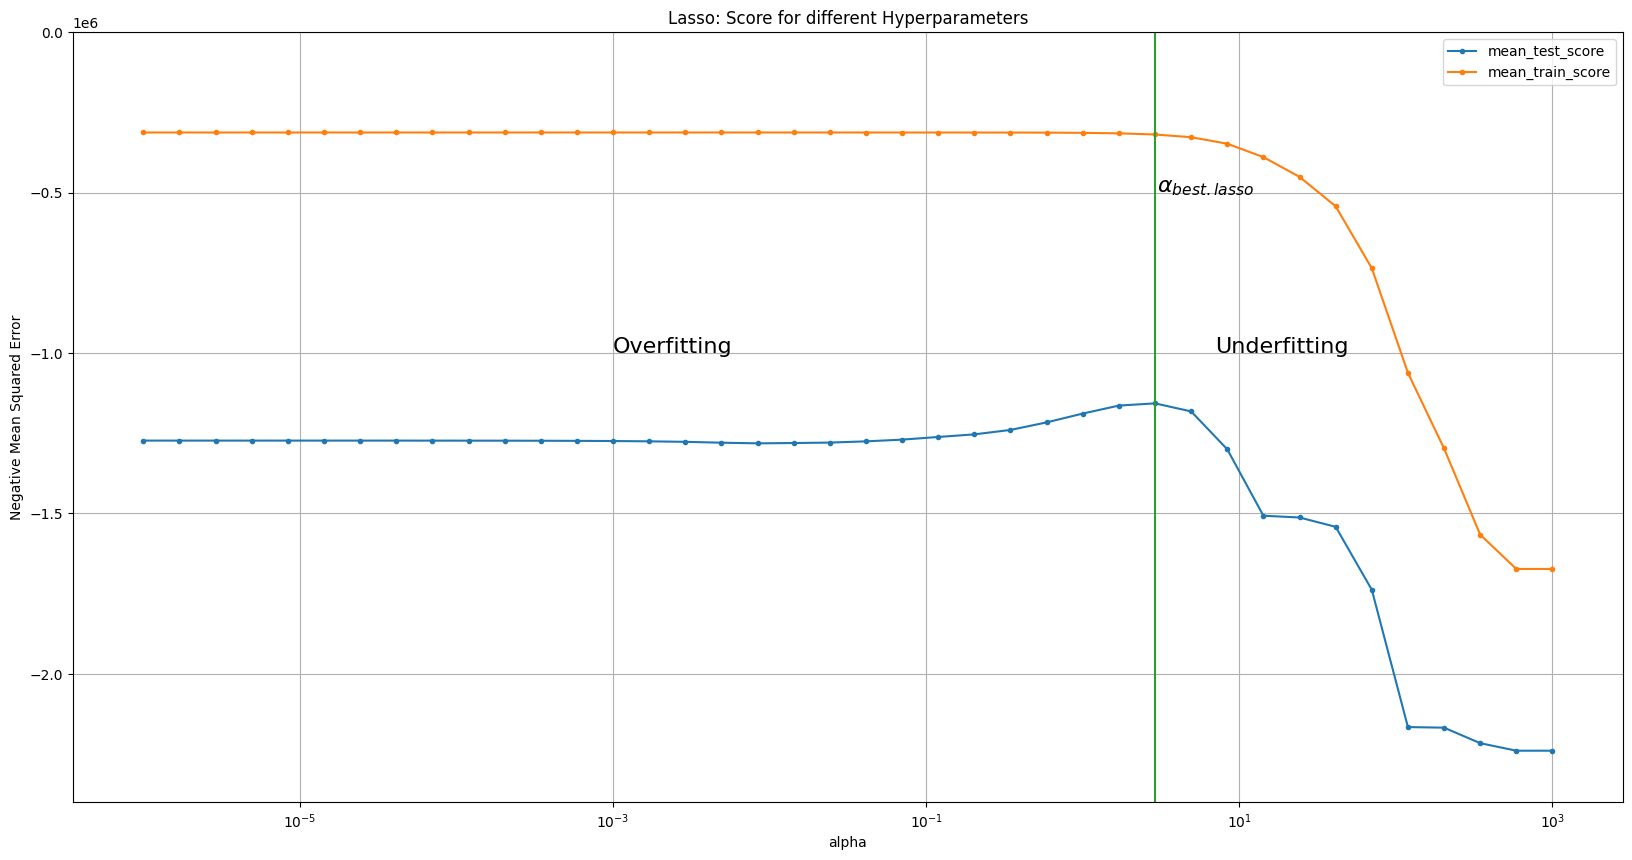

In [110]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.plot(param_grid['alpha'], lasso_cv_results['mean_test_score'], marker='.', label='mean_test_score')
ax.plot(param_grid['alpha'], lasso_cv_results['mean_train_score'], marker='.', label='mean_train_score')

lasso_alpha = lasso_search_cv.best_params_['alpha']
ax.plot([lasso_alpha, lasso_alpha],[-2.4e6, 0], ls = '-')
ax.text(lasso_alpha+0.1, -0.5e6, r'$\alpha_{best.lasso}$', fontsize=16, color='black')

ax.text(7, -1e6, 'Underfitting', fontsize=16, color='black')
ax.text(1e-3, -1e6, 'Overfitting', fontsize=16, color='black')

ax.set_ylim(-2.4e6, 0)
ax.set_xscale('log')
ax.set_title('Lasso: Score for different Hyperparameters')
ax.set_xlabel('alpha')
ax.set_ylabel('Negative Mean Squared Error')
ax.grid()
ax.legend()


### KernelRidge
* bei KernelRidge ist Overfitting und Underfitting bei sehr kleinen bzw sehr großen alphas sehr stark ausgeprägt

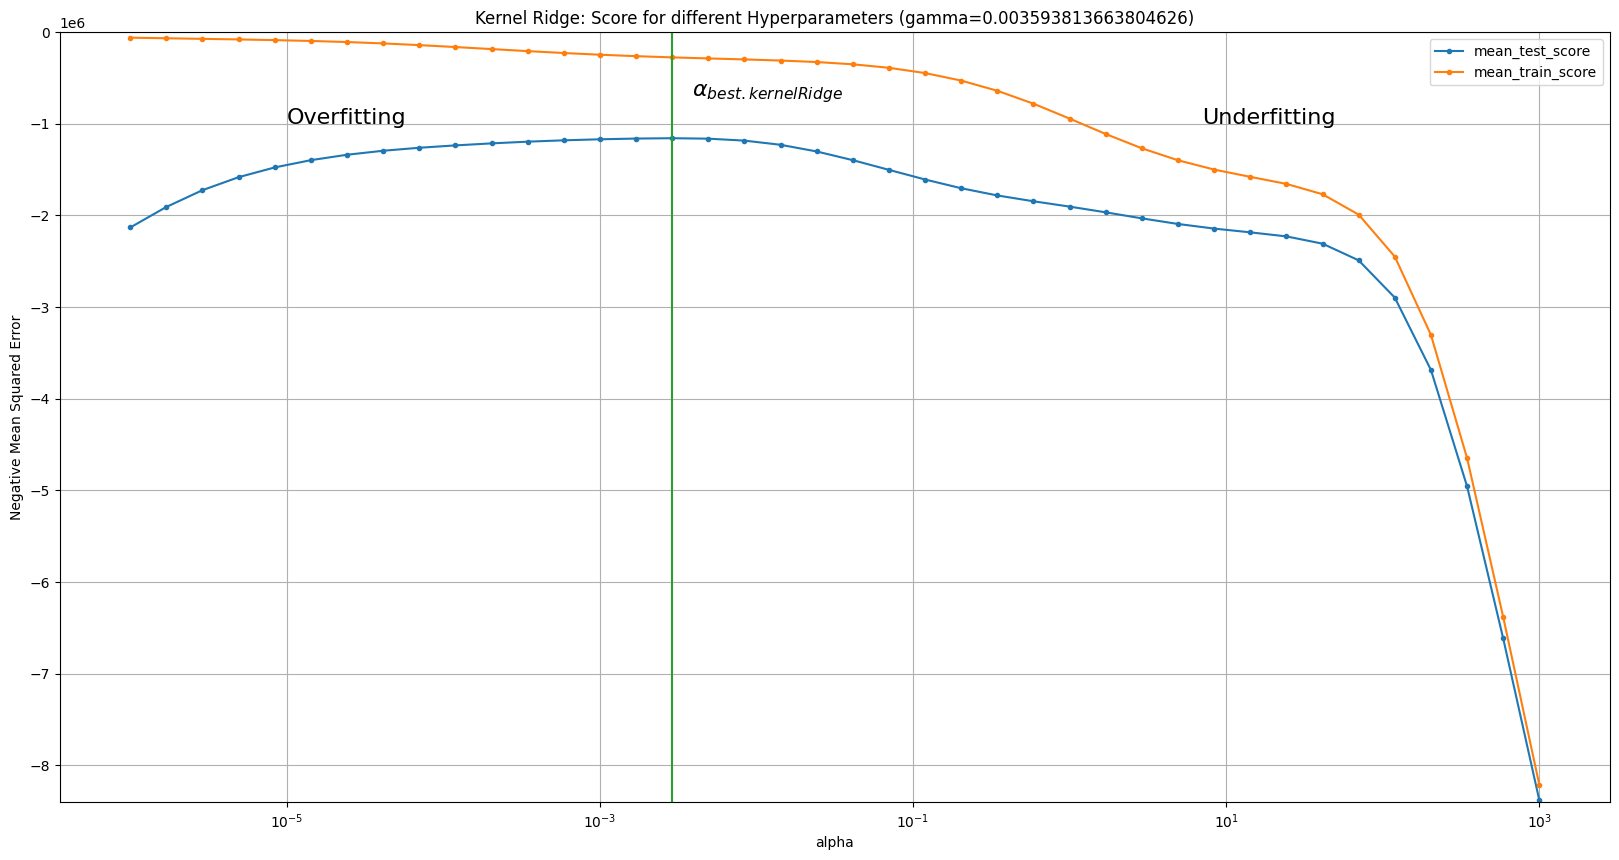

In [122]:
best_gamma = kernelRidge_search_cv.best_params_['gamma']    # es wird das beste gamma genommen
kernelRidge_cv_results = kernelRidge_cv_results[kernelRidge_cv_results['param_gamma'] == best_gamma]

fig, ax = plt.subplots(1, figsize=(20, 10))
ax.plot(kernelRidge_param_grid['alpha'], kernelRidge_cv_results['mean_test_score'], marker='.', label='mean_test_score')
ax.plot(kernelRidge_param_grid['alpha'], kernelRidge_cv_results['mean_train_score'], marker='.', label='mean_train_score')

kernelRidge_alpha = kernelRidge_search_cv.best_params_['alpha']
ax.plot([kernelRidge_alpha, kernelRidge_alpha],[-8.4e6, 0], ls = '-')
ax.text(kernelRidge_alpha+0.001, -0.7e6, r'$\alpha_{best.kernelRidge}$', fontsize=16, color='black')

ax.text(7, -1e6, 'Underfitting', fontsize=16, color='black')
ax.text(1e-5, -1e6, 'Overfitting', fontsize=16, color='black')

ax.set_xscale('log')
ax.set_ylim(-8.4e6, 0)
ax.set_title(f"Kernel Ridge: Score for different Hyperparameters (gamma={best_gamma})")
ax.set_xlabel("alpha")
ax.set_ylabel("Negative Mean Squared Error")
ax.grid()
ax.legend()

#### Es wird das Modell mit den optimalen Paramentern ermittelt
+ dafür werden die Testscores der einzelnen Modelle verglichen

In [125]:
best_ridge_score = ridge_search_cv.best_score_
best_lasso_score = lasso_search_cv.best_score_
best_kernel_ridge_score = kernelRidge_search_cv.best_score_

print("Ridge best mean test score:        ", best_ridge_score)
print("Lasso best mean test score:        ", best_lasso_score)
print("Kernel Ridge best mean test score: ", best_kernel_ridge_score)

scores = {
    "Ridge": best_ridge_score,
    "Lasso": best_lasso_score,
    "Kernel Ridge": best_kernel_ridge_score
}
best_model_name = max(scores, key=scores.get)
print(f"\n✅ Bestes Modell: {best_model_name} mit Score = {scores[best_model_name]}")


Ridge best mean test score:         -1167240.6238771302
Lasso best mean test score:         -1157118.9689050138
Kernel Ridge best mean test score:  -1157400.4169352646

✅ Bestes Modell: Lasso mit Score = -1157118.9689050138


## 3) Plotten des besten Modells
Es wird der Einfluss aller Features auf die Vorhersage des Lasso Modells dargestellt

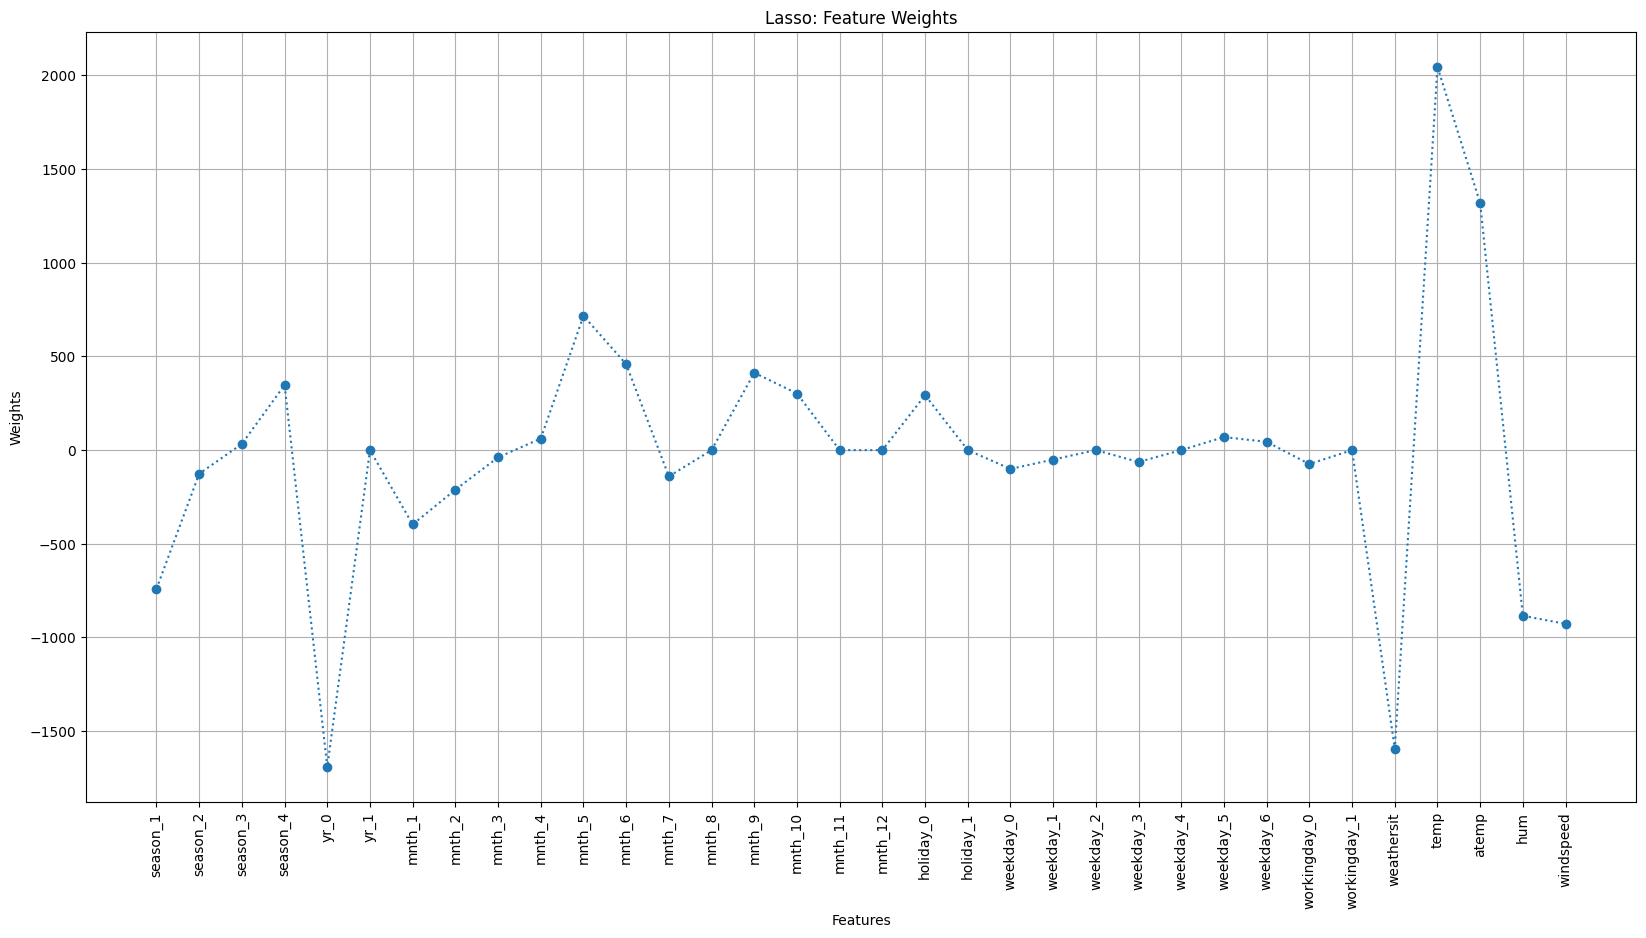

In [132]:
# Modell mit besten Parametern trainieren
best_lasso = Lasso(alpha=lasso_search_cv.best_params_['alpha'])
best_lasso.fit(X_train_final, y_train)
coefficients = best_lasso.coef_

fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(X_train_final.columns, coefficients, marker='o', ls=':')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Lasso: Feature Weights')
plt.xticks(rotation=90)
ax.grid()
plt.show()

## 4) Vorhersage des besten Modells
Vergleich der echten Daten zu der Vorhersage am Trainingsdatensatz

Mean Squared Error: 1264419.82


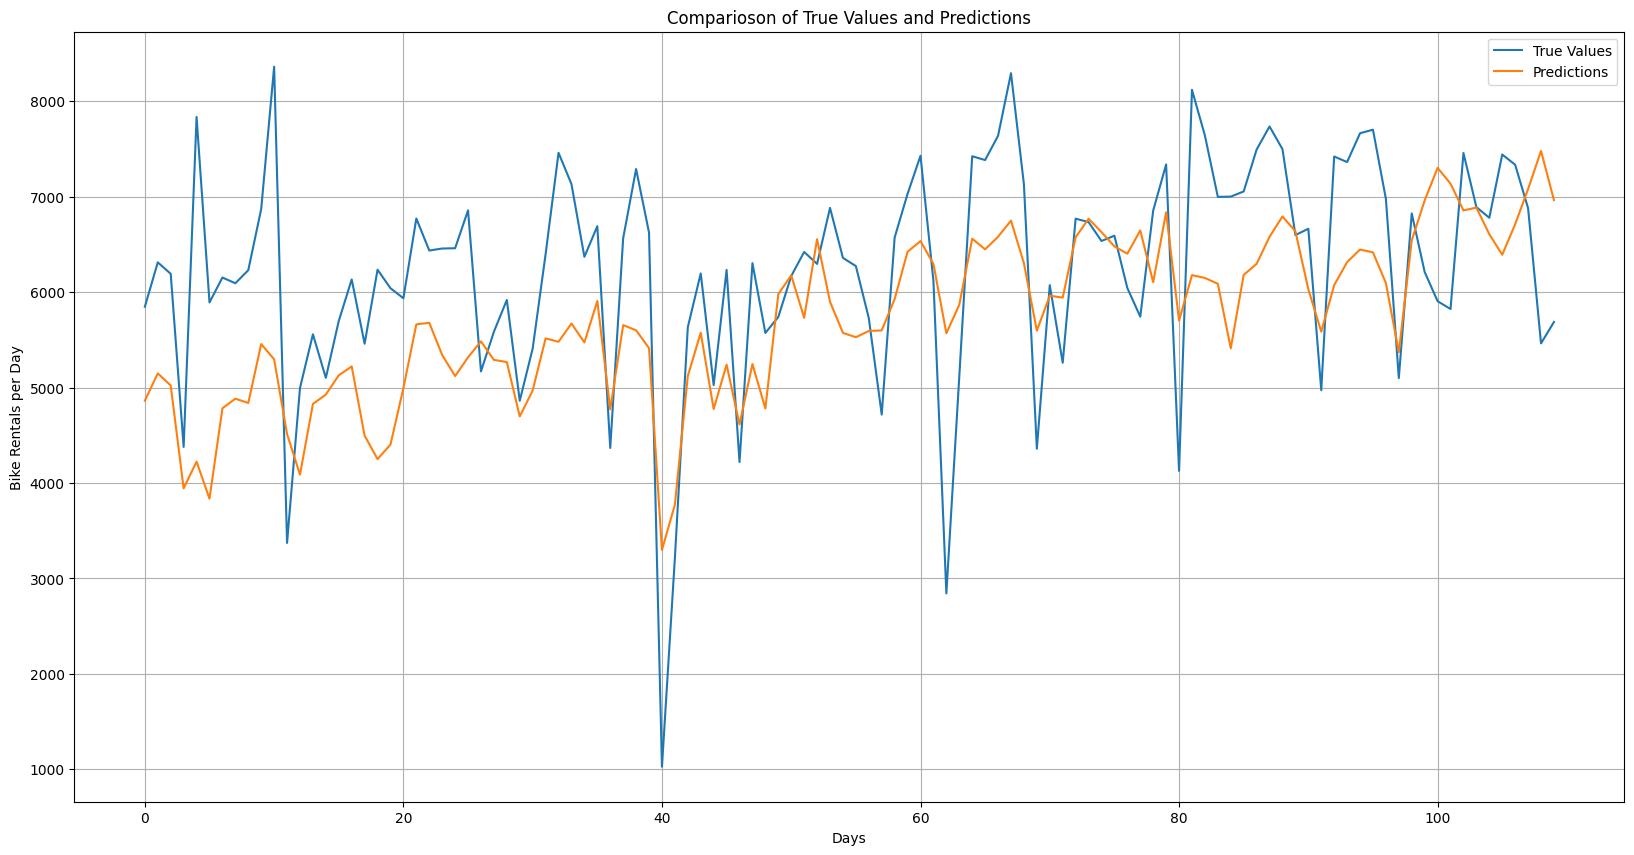

In [154]:
y_pred = best_lasso.predict(X_valid_final)

plt.figure(figsize=(20, 10))
plt.plot(y_valid.values, label='True Values')
plt.plot(y_pred, label='Predictions')
plt.title('Comparioson of True Values and Predictions')
plt.xlabel('Days')
plt.ylabel('Bike Rentals per Day')
plt.legend()
plt.grid(True)



# MSE berechnen
mse = mean_squared_error(y_valid, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

## 5) Testdatensatz Handling

Einlesen des Testdatensatzes

In [ ]:
test_data = pd.read_csv(dirpath + 'test_data.csv')

Feature Transformation und Normalisierung

In [ ]:
columns = ['intday', 'season', 'yr', 'mnth', 'holiday',
       'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed']

X_test = bike_rental[columns]  # Trainingsfeatures
y_test = bike_rental['cnt']    # Trainingslabels

X_test_enc = enc.transform(X_test[enc_features])
X_test_enc = pd.DataFrame(X_test_enc, columns=enc.get_feature_names_out(enc_features))

X_test_scale = scaler.transform(X_test[num_features])
X_test_scale = pd.DataFrame(X_test_scale, columns=num_features)

X_test_final = pd.concat((X_test_enc, X_test_scale), axis=1)

Vorhersage mit dem besten Modell

In [ ]:
y_test_pred = best_lasso.predict(X_test_final)

#### Vergleich Testdatensatz mit vorhergesagten Werten

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid.values, label='True Values')
plt.plot(y_test_pred, label='Predictions')
plt.title('Comparioson of True Values and Predictions')
plt.xlabel('Days')
plt.ylabel('Bike Rentals per Day')
plt.legend()
plt.grid(True)



# MSE berechnen
mse = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error: {mse:.2f}')

## 6) Speicherung des besten Models mittels joblib

In [158]:
joblib.dump(best_lasso, 'Fink_UE2_Model.joblib')

['Fink_UE2_Model.joblib']